In [1]:
# based on examples from https://github.com/pytorch/examples
# https://github.com/L1aoXingyu/pytorch-beginner/https://github.com/L1aoXingyu/pytorch-beginner/
# https://github.com/bfarzin/pytorch_aae/blob/master/main_aae.py
# https://github.com/artemsavkin/aae/blob/master/aae.ipynb
import argparse
import os
import torch
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch.distributions as D


In [18]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_reconstructs(encoder, decoder, x, epoch):
        with torch.no_grad():
            x = x.to(device)
            sample = decoder(encoder(x))
            save_image(x.view(x.shape[0], 1, 28, 28),
                       'results/originals_' + str(epoch) + '.png')
            save_image(sample.view(x.shape[0], 1, 28, 28),
                       'results/reconstructs_' + str(epoch) + '.png')

def save_random_reconstructs(model, nz, epoch):
        with torch.no_grad():
            sample = torch.randn(64, nz).to(device)
            sample = model(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')


# Image processing
#transform = transforms.Compose([
#                transforms.ToTensor(),
#                transforms.Normalize(mean=(0.5,),   # 3 for RGB channels
#                                     std=(0.5,))])                
transform = transforms.ToTensor()

In [19]:
class Discriminator(nn.Module):
    """
    Classifies real distribution and fake (generated) distribution.
    """
    def __init__(self, nin, nh1, nh2):
        super(Discriminator, self).__init__()
        self.nin = nin
        self.main = nn.Sequential(
                nn.Linear(nin, nh1),
                nn.ReLU(),
                nn.Linear(nh1, nh2),
                nn.ReLU(),
                nn.Linear(nh2, 1),
                nn.Sigmoid()
                )

    def forward(self, input):
        return self.main(input)

class Encoder(nn.Module):
    """
    Encodes high dimensional data point into
    a low dimension latent space. 
    """

    def __init__(self, nin, nout, nh1, nh2):
        super(Encoder, self).__init__()
        self.nin = nin
        self.nout = nout
        self.main = nn.Sequential(
            nn.Linear(nin, nh1),
            nn.ReLU(),
            nn.Linear(nh1, nh2),
            nn.ReLU(),
            nn.Linear(nh2, nout),
            #nn.ReLU(),
        )

    def forward(self, input):
        return self.main(input.view(-1, self.nin))


In [20]:
# the generator is the decoder
class Decoder(nn.Module):
    """
    Reconstructs a input from the latent, low dimensional space, into
    the original data space.
    """

    def __init__(self, nin, nout, nh1, nh2):
        super(Decoder, self).__init__()
        self.nin = nin
        self.nout = nout
        self.main = nn.Sequential(
            nn.Linear(nin, nh1),
            nn.ReLU(),
            nn.Linear(nh1, nh2),
            nn.ReLU(),
            nn.Linear(nh2, nout),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.main(z)

In [21]:
# parameters
nin = 28*28
nz = 64
batchSize = 256
epochs = 10
beta = 0.5
lr = 2e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/", train=True, download=True, transform=transform
    ),
    batch_size=batchSize,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data/", train=False, transform=transform),
    batch_size=batchSize,
    shuffle=True,
)


In [26]:
Dx = Discriminator(nin, 512, 512).to(device)
Dz = Discriminator(nz, 512, 512).to(device)
Gx = Decoder(nz, nin, 4024, 1024).to(device)
Gz = Encoder(nin, nz, 1024, 4024).to(device)
criterion = nn.BCELoss()
dx_optimizer = torch.optim.Adam(Dx.parameters(), )
dz_optimizer = torch.optim.Adam(Dz.parameters(), )
gx_optimizer = torch.optim.Adam(Gx.parameters(), )
gz_optimizer = torch.optim.Adam(Gz.parameters(), )
bce = nn.BCELoss()
mse = nn.MSELoss()


In [23]:
def trainGx(G, D, optimizer, data):
    batch_size = data.shape[0]
    


def train(epochstart, epochstop):
    for epoch in range(epochstart, epochstop):
        for idx, (data, _) in enumerate(train_loader):
            batch_size = data.shape[0]
            
            # generator Gz turn
            dz_optimizer.zero_grad()
            gz_optimizer.zero_grad()
            labels_real = torch.ones(batch_size, 1).to(device)
            x = data.view(-1, nin).to(device)
            zfake = Gz(x)
            pred = Dz(zfake)
            lossGz = criterion(pred, labels_real)
            lossGz.backward()
            gz_optimizer.step()
            G_z = pred.mean().item()
            
            # generator Gx turn
            dx_optimizer.zero_grad()
            gx_optimizer.zero_grad()
            labels_real = torch.ones(batch_size, 1).to(device)
            z = torch.randn(batch_size, nz).to(device)
            xfake = Gx(z)
            pred = Dx(xfake)
            lossGx = criterion(pred, labels_real)
            lossGx.backward()
            gx_optimizer.step()
            G_x = pred.mean().item()
            
            # discriminator Dx turn
            labels_real = torch.ones(batch_size, 1).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)
            dx_optimizer.zero_grad()
            gx_optimizer.zero_grad()
            xreal = data.view(-1, nin).to(device)
            predreal = Dx(xreal)
            lossDreal = criterion(predreal, labels_real)
            D_x = predreal.mean().item()
            z = torch.randn(batch_size, nz).to(device)
            xfake = Gx(z)
            predfake = Dx(xfake)
            lossDfake = criterion(predfake, labels_fake)
            lossDx = lossDreal + lossDfake
            lossDx.backward()
            dx_optimizer.step()
            D_x = predfake.mean().item()
            
            
            # discriminator Dz turn
            labels_real = torch.ones(batch_size, 1).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)
            dz_optimizer.zero_grad()
            gz_optimizer.zero_grad()
            x = data.view(-1, nin).to(device)
            zreal = torch.randn(batch_size, nz).to(device)
            predreal = Dz(zreal)
            lossDreal = criterion(predreal, labels_real)
            D_z = predreal.mean().item()
            zfake = Gz(x)
            predfake = Dz(zfake)
            lossDfake = criterion(predfake, labels_fake)
            lossDz = lossDreal + lossDfake
            lossDz.backward()
            dz_optimizer.step()
            D_z = predfake.mean().item()
            
            if idx % 2000 == 0:
                #print(D_x, D_z, DG_z, lossD.mean().item(), lossG.mean().item(), )
                print(lossDx.mean().item(),
                      lossDz.mean().item(),
                      lossGx.mean().item(),
                      lossGz.mean().item(),
                     )
                #fake_images = Gx(z)
                #fake_images = fake_images.view(data.size(0), 1, 28, 28).cpu()
                #fake_images = denorm(fake_images)
                #save_image(denorm(fake_images.data), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
                #grid_img = make_grid(fake_images, nrow=16)
                #plt.imshow(grid_img.permute(1,2,0))


In [24]:
train(10, 15)

1.5162813663482666 1.4673881530761719 0.7192159295082092 0.6830266714096069
7.57611041990458e-06 1.4992105960845947 11.971403121948242 0.5118415355682373
0.0 3.2645561695098877 100.0 0.18938899040222168
4.656613428188905e-10 0.28914397954940796 100.0 5.045618057250977
0.0 0.37497881054878235 100.0 2.0731050968170166


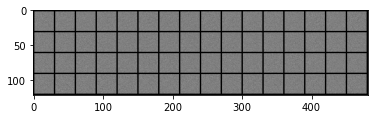

In [27]:
Gx.to(device)
sample = torch.randn(64, nz).to(device)
sample = Gx(sample).cpu()
sample = sample.view(-1, 1, 28, 28)
sample.shape
grid_img = make_grid(sample, nrow=16)
plt.imshow(grid_img.permute(1,2,0))
